In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Flatten, GRU, Dropout, SimpleRNN,SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Read Data

In [3]:
df = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df.shape

(20491, 2)

In [4]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

## Label Review Rating


*   0 if rating is 1 or 2 or 3
*   1 if rating is 4 or 5

In [5]:
df['label'] = np.array(df['Rating'].apply(lambda x: 1 if x > 3 else 0))
df.head()

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


## Preprocessing Review Text


*   remove integer values
*   breakdown to words by space delimiter 
*   remove stopwords using nltk library
*   stemmin

In [6]:
# nltk.download('stopwords')
stop_words = stopwords.words('english')

In [7]:
def preprocess(text):
    text = re.sub(r'\d+',' ',text)
    text = text.split()
    text = ' '.join([w for w in text if not w.lower().strip() in stop_words])
    return text

In [8]:
df['Review'] = df['Review'].apply(preprocess)

## Training and Testing Data Split

> Split data into train and test datasets with equal proportion of label.

In [9]:

X_train, X_test, y_train, y_test = train_test_split(df['Review'].values,df['label'].values,
                                                    test_size=0.2, random_state=1,stratify=df['label'].values)

## Tokenization

*   convert to lower case (default)
*   remove punctuation
*   integer encoding to word - map each word with unique index for each word with most common as 1 to least common xxx
*   sequence encoding to review
*   NOTE: require data to be str format

AVOID Data Leakage
*  build tokenizer using only training data





In [10]:
NWORDS = 10000
tknz = Tokenizer(num_words=NWORDS,oov_token ="_OOV")
tknz.fit_on_texts(X_train)

train_seq = tknz.texts_to_sequences(X_train)
test_seq = tknz.texts_to_sequences(X_test)

In [11]:
print(len(tknz.word_index))

44178


## Padding
*   get the length of longest review text 
*   set all sequences to a uniform length with the longest review length by filling in with 0 
*   padding flag 'pre': pad 0 in the beginning
*   padding flag 'post': pad 0 in the end



In [12]:
MAX_SEQ_LEN =np.max(list(map(lambda x: len(x), train_seq)))+1
MAX_SEQ_LEN

1941

In [13]:
pad_train_seq = pad_sequences(train_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')
pad_test_seq = pad_sequences(test_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')


## Build Models

In [14]:
EMBED_DIM = 32
BATCH_SIZE = 500
EPOCH = 20

In [15]:
def show_model_summary(model):
  print()
  print(model.summary())
  print()

In [16]:
def build_BiGRU(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS, output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.25))
  model.add(Bidirectional(GRU(32)))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
  
  return model

In [17]:
def fit_model(model, model_name):
  history = model.fit(pad_train_seq,y_train,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,epochs=EPOCH,
                    callbacks=[
                            EarlyStopping(
                            monitor='val_accuracy',
                            patience=3,
                            restore_best_weights=True
                        )
                        
                    ]
                   )
  model.save(model_name)
  print(pd.DataFrame(model.history.history))
  return history

In [18]:
def plot_PM(history):
  fig = px.line(
    history.history, y = ['auc', 'val_auc','accuracy','val_accuracy'],
    labels={'index': 'Epoch', 'value': 'Accuracy/AUC Score'},
    width = 600, height = 400,
    
  )
  fig.update_layout(legend_title = "Metrics")
  fig.show()

2023-02-03 15:29:40.552221: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1941, 32)          320000    
_________________________________________________________________
dropout (Dropout)            (None, 1941, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12672     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 332,737
Trainable params: 332,737
Non-trainable params: 0
_________________________________________________

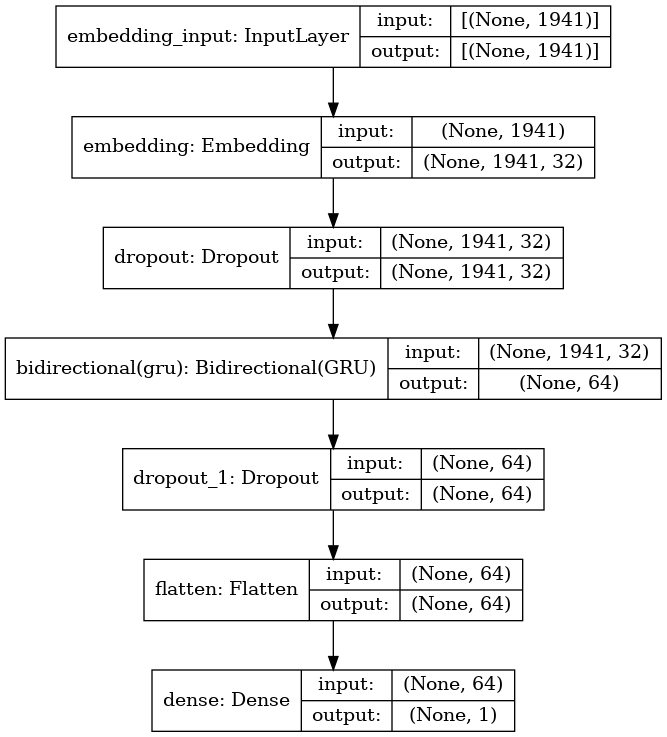

In [19]:
grumodel = build_BiGRU(EMBED_DIM)
show_model_summary(grumodel)
plot_model(grumodel,show_shapes=True)

In [20]:
gruhistory = fit_model(grumodel,'./saved_model/grumodel.h5')
plot_PM(gruhistory)
gru_results = grumodel.evaluate(pad_test_seq,y_test)
gru_results

2023-02-03 15:29:42.742857: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
27/27 [==============================] - 151s 5s/step - loss: 0.6188 - accuracy: 0.7256 - auc: 0.5204 - val_loss: 0.5445 - val_accuracy: 0.7511 - val_auc: 0.8492
Epoch 2/20
27/27 [==============================] - 144s 5s/step - loss: 0.5364 - accuracy: 0.7329 - auc: 0.8202 - val_loss: 0.4641 - val_accuracy: 0.7514 - val_auc: 0.8879
Epoch 3/20
27/27 [==============================] - 144s 5s/step - loss: 0.3996 - accuracy: 0.8104 - auc: 0.8805 - val_loss: 0.3241 - val_accuracy: 0.8588 - val_auc: 0.9163
Epoch 4/20
27/27 [==============================] - 143s 5s/step - loss: 0.2973 - accuracy: 0.8835 - auc: 0.9363 - val_loss: 0.2922 - val_accuracy: 0.8713 - val_auc: 0.9272
Epoch 5/20
27/27 [==============================] - 145s 5s/step - loss: 0.2390 - accuracy: 0.9072 - auc: 0.9568 - val_loss: 0.2829 - val_accuracy: 0.8774 - val_auc: 0.9323
Epoch 6/20
27/27 [==============================] - 145s 5s/step - loss: 0.2023 - accuracy: 0.9249 - auc: 0.9687 - val_loss: 0.2888 - v

129/129 [==============================] - 115s 890ms/step - loss: 0.3436 - accuracy: 0.8639 - auc: 0.9154


[0.34356382489204407, 0.8638692498207092, 0.9154051542282104]

In [21]:
def build_BiGRU_1(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS, output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(32,return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
  
  return model


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1941, 32)          320000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1941, 32)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1941, 64)          12672     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1941, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 124224)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 124225    
Total params: 456,897
Trainable params: 456,897
Non-trainable params: 0
_______________________________________________

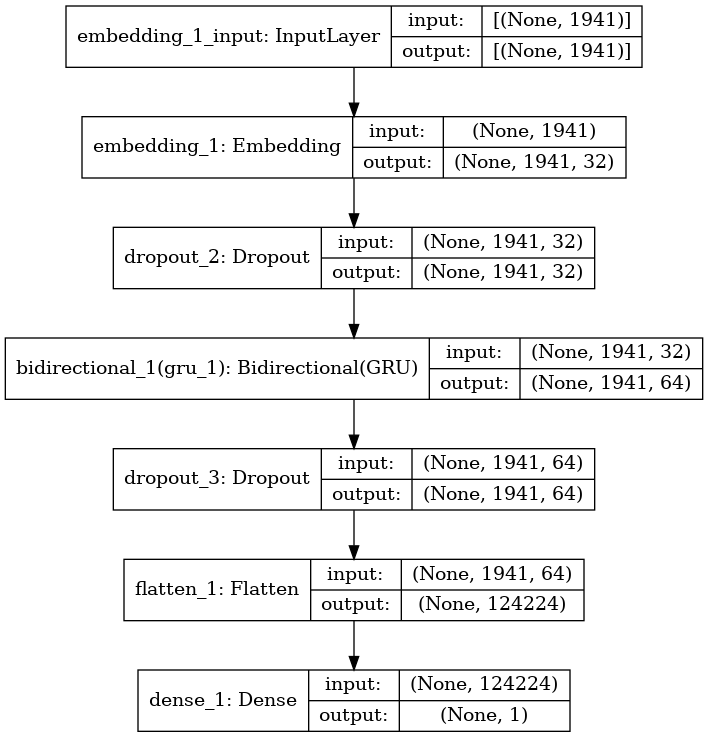

In [22]:
grumodel1 = build_BiGRU_1(EMBED_DIM)
show_model_summary(grumodel1)
plot_model(grumodel1,show_shapes=True)

In [23]:
gruhistory1 = fit_model(grumodel1,'./saved_model/grumodel1.h5')
plot_PM(gruhistory1)
gru_results1 = grumodel1.evaluate(pad_test_seq,y_test)
gru_results1

Epoch 1/20
27/27 [==============================] - 163s 6s/step - loss: 0.5897 - accuracy: 0.7326 - auc: 0.5381 - val_loss: 0.5397 - val_accuracy: 0.7508 - val_auc: 0.7382
Epoch 2/20
27/27 [==============================] - 156s 6s/step - loss: 0.4871 - accuracy: 0.7629 - auc: 0.8202 - val_loss: 0.3434 - val_accuracy: 0.8695 - val_auc: 0.9241
Epoch 3/20
27/27 [==============================] - 155s 6s/step - loss: 0.2787 - accuracy: 0.8889 - auc: 0.9342 - val_loss: 0.2274 - val_accuracy: 0.9064 - val_auc: 0.9544
Epoch 4/20
27/27 [==============================] - 153s 6s/step - loss: 0.1946 - accuracy: 0.9229 - auc: 0.9683 - val_loss: 0.2141 - val_accuracy: 0.9143 - val_auc: 0.9601
Epoch 5/20
27/27 [==============================] - 155s 6s/step - loss: 0.1566 - accuracy: 0.9407 - auc: 0.9790 - val_loss: 0.2199 - val_accuracy: 0.9125 - val_auc: 0.9596
Epoch 6/20
27/27 [==============================] - 155s 6s/step - loss: 0.1348 - accuracy: 0.9494 - auc: 0.9844 - val_loss: 0.2441 - v

129/129 [==============================] - 117s 911ms/step - loss: 0.2664 - accuracy: 0.8944 - auc: 0.9426


[0.26640310883522034, 0.8943644762039185, 0.9425836801528931]

In [24]:
def build_BiGRU_2(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS, output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(64,return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
  
  return model


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1941, 32)          320000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1941, 32)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1941, 128)         37632     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1941, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 248448)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 248449    
Total params: 606,081
Trainable params: 606,081
Non-trainable params: 0
_______________________________________________

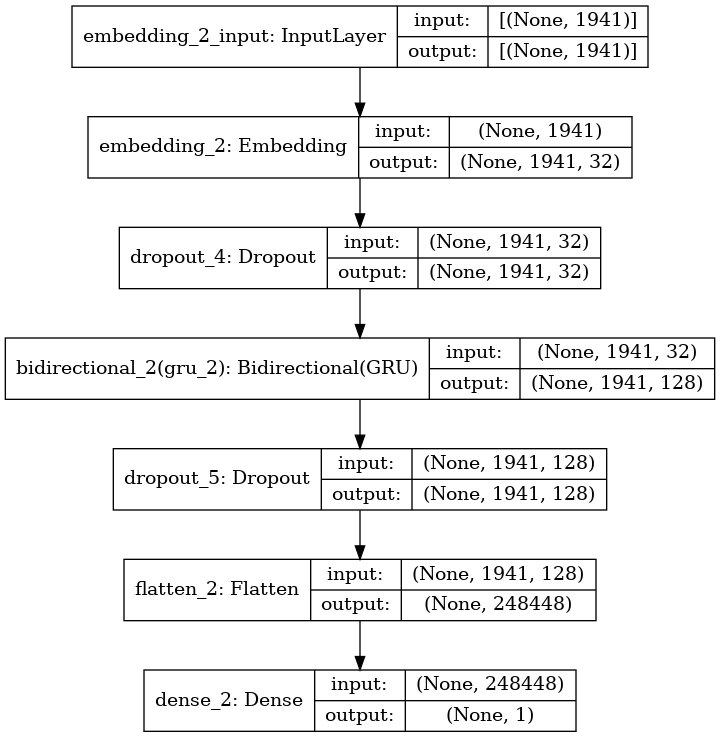

In [25]:
grumodel2 = build_BiGRU_2(EMBED_DIM)
show_model_summary(grumodel2)
plot_model(grumodel2,show_shapes=True)

In [26]:
gruhistory2 = fit_model(grumodel2,'./saved_model/grumodel2.h5')
plot_PM(gruhistory2)
gru_results2 = grumodel2.evaluate(pad_test_seq,y_test)
gru_results2

Epoch 1/20
27/27 [==============================] - 253s 9s/step - loss: 0.6135 - accuracy: 0.7128 - auc: 0.5206 - val_loss: 0.5531 - val_accuracy: 0.7502 - val_auc: 0.6902
Epoch 2/20
27/27 [==============================] - 243s 9s/step - loss: 0.5016 - accuracy: 0.7549 - auc: 0.7930 - val_loss: 0.3477 - val_accuracy: 0.8567 - val_auc: 0.9196
Epoch 3/20
27/27 [==============================] - 245s 9s/step - loss: 0.2815 - accuracy: 0.8869 - auc: 0.9324 - val_loss: 0.2388 - val_accuracy: 0.9021 - val_auc: 0.9518
Epoch 4/20
27/27 [==============================] - 245s 9s/step - loss: 0.2004 - accuracy: 0.9229 - auc: 0.9663 - val_loss: 0.2152 - val_accuracy: 0.9134 - val_auc: 0.9584
Epoch 5/20
27/27 [==============================] - 249s 9s/step - loss: 0.1554 - accuracy: 0.9384 - auc: 0.9792 - val_loss: 0.2180 - val_accuracy: 0.9161 - val_auc: 0.9578
Epoch 6/20
27/27 [==============================] - 250s 9s/step - loss: 0.1269 - accuracy: 0.9526 - auc: 0.9857 - val_loss: 0.2344 - v

129/129 [==============================] - 132s 1s/step - loss: 0.2793 - accuracy: 0.8992 - auc: 0.9397


[0.2793045938014984, 0.8992437124252319, 0.9396876692771912]

Performance Evaluation
* In terms of performance metrics - Model 2 performs the best accuracy score whereas Model1 achieves AUC score.  